## Working environment 
**obs: not part of the solution**

For explaining the steps of a project, using a notebook is useful. Nevertheless, I store all the project core code in the "source" folder, thus, I need to change the working environment.

In [1]:
import os

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("../src")

## Imports

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Project configuration settings

Ideally, we should add all the manually coded parameters as configuration parameters. For this case, I am adding only the most relevant parameters as Global variables. For a production environment is recommended to store everything in config files and to use a specific framework such as Hydra or OmegaConf.

In [3]:
DATA_PATH = "./data"
CLIENT_FILE_NAME = "client.csv"

In [4]:
client_path = os.path.join(DATA_PATH, CLIENT_FILE_NAME)

df = pd.read_csv(client_path, index_col="user_id")

In [5]:
df["joined_at_least_1_hub"] = df["joined_at_least_1_hub"].apply(lambda x: True if x == True else False)

## Bayesian AB Testing

After understanding the data and the purpose of the task, I started to think about the classical hypothesis testing framework which is to understand the data, define the most appropriate statistical test, compute the p-value and make some conclusions about the statical significance.

When deciding about the most appropriate statistical test, the first one that came to my mind was the t-test but when checking about the assumptions about the data. One of the assumptions is that both samples have to be approximately normally distributed. We could think that we need to verify that first by using some other tests but let's remember that **we are dealing with proportions** this can never be normally distributed because the values can never be negative and can never be greater than one.

With all this, I decided that I preferred to follow a bayesian approach where I would not need to make any assumptions and I would not need a p-value at all.

In [6]:
df.groupby("client")["joined_at_least_1_hub"].mean()

client
new_client    0.860697
web_client    0.837567
Name: joined_at_least_1_hub, dtype: float64

In [7]:
df.groupby("client")["joined_at_least_1_hub"].count()

client
new_client    1809
web_client    1496
Name: joined_at_least_1_hub, dtype: int64

In [8]:
web_client_df = df[df["client"] == "web_client"]

with pm.Model() as model_web_bernoulli:
    p = pm.Uniform("p", lower=0, upper=1)
    like = pm.Bernoulli(
        "likelihood", p=p, observed=web_client_df["joined_at_least_1_hub"]
    )

In [9]:
with model_web_bernoulli:
    samples_web_bernoulli = pm.sample(2000, tune=1000)

/tmp/ipykernel_52291/2545800191.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  samples_web_bernoulli = pm.sample(2000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
/home/ejar/Documents/GitEjar/FACEIT/env/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<AxesSubplot: title={'center': 'p'}>

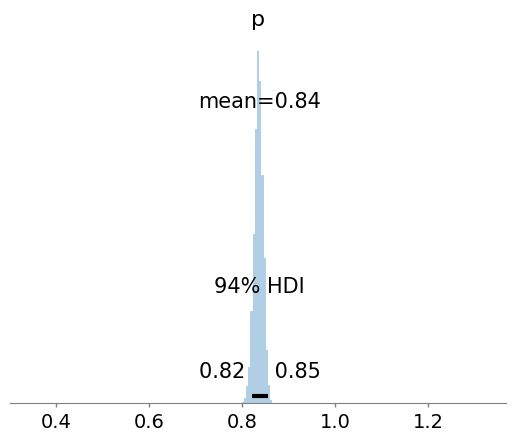

In [10]:
az.plot_posterior(samples_web_bernoulli, kind="hist")

Got error No model on context stack. trying to find log_likelihood in translation.


<AxesSubplot: title={'center': 'p'}>

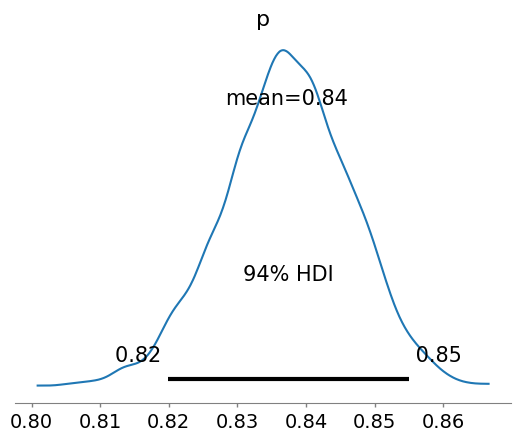

In [11]:
az.plot_posterior(samples_web_bernoulli)

In [12]:
new_client_df = df[df["client"] == "new_client"]

with pm.Model() as model_new_bernoulli:
    p = pm.Uniform("p", lower=0, upper=1)
    like = pm.Bernoulli(
        "likelihood", p=p, observed=new_client_df["joined_at_least_1_hub"]
    )

In [13]:
with model_new_bernoulli:
    samples_new_bernoulli = pm.sample(2000, tune=1000)

/tmp/ipykernel_52291/2937011495.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  samples_new_bernoulli = pm.sample(2000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
/home/ejar/Documents/GitEjar/FACEIT/env/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<AxesSubplot: title={'center': 'p'}>

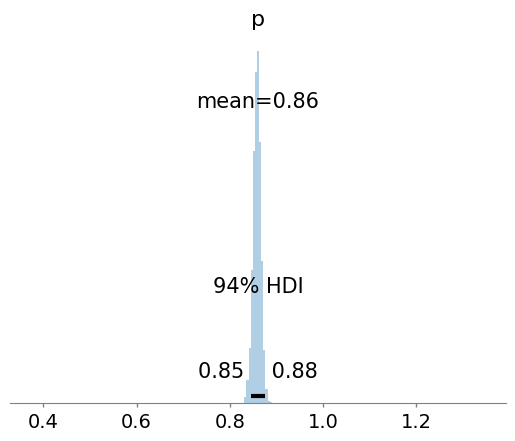

In [14]:
az.plot_posterior(samples_new_bernoulli, kind="hist")

Got error No model on context stack. trying to find log_likelihood in translation.


<AxesSubplot: title={'center': 'p'}>

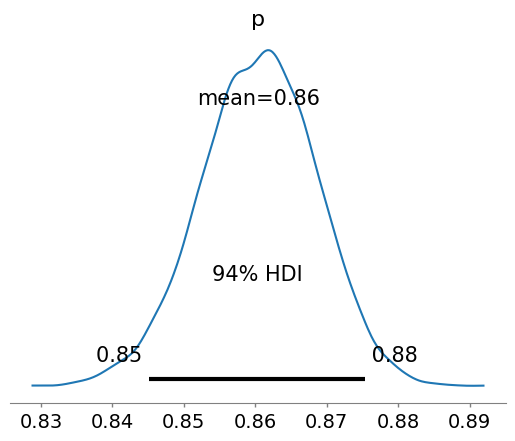

In [15]:
az.plot_posterior(samples_new_bernoulli)

In [16]:
with pm.Model() as model_both:
    p_web = pm.Uniform("p_web_client")
    like_control = pm.Binomial(
        'like_web', 
        n=len(web_client_df), 
        p=p_web, 
        observed=len(web_client_df[web_client_df["joined_at_least_1_hub"] == True])
    )
    
    p_new = pm.Uniform("p_new_client")
    like_test = pm.Binomial(
        'like_new', 
        n=len(new_client_df), 
        p=p_new, 
        observed=len(new_client_df[new_client_df["joined_at_least_1_hub"] == True])
    )

    p_diff = pm.Deterministic("p_new_web_diff", p_new - p_web)

In [17]:
with model_both:
    trace = pm.sample(2000)

/tmp/ipykernel_52291/1675604489.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_new_client, p_web_client]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
/home/ejar/Documents/GitEjar/FACEIT/env/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


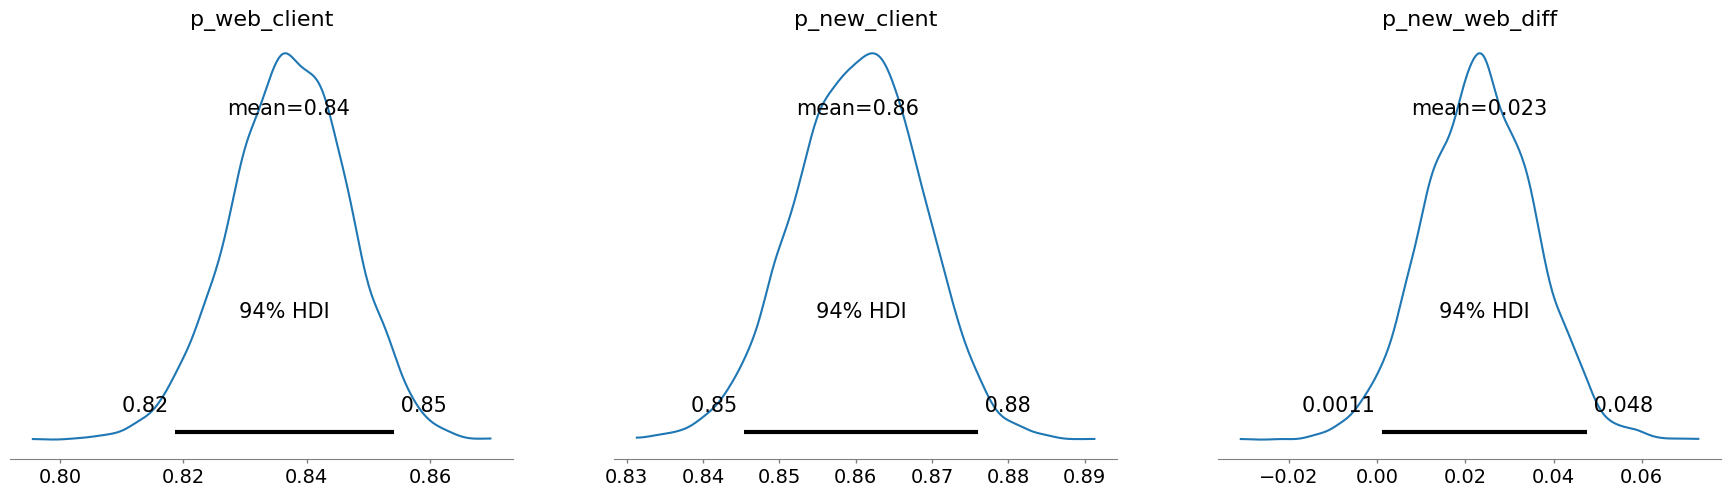

In [18]:
az.plot_posterior(trace, round_to=2);

# Posterior distribution of the proportions

Now that we have the posterior distributions of both means (new and web client), what we want to see is if our distributions are overlapping. We do this to check is there were any changes when changing to the new client, to see if there were some significant changes or not (to answer the hypothesis)

What we observe here is that the difference of means will very likely lie in the interval [0.0, 0.06] which shows an small increase on the average amount of users that joined at least one hub using the new client. One important thing here is that even though is highly likely that the new client brings more users to join the hub. There is still a small chance that we are actually getting less users.

## Cost function

It can be helpful to add some expected revenue amount (number of users joining one hub) to our metric of interest in order to understand it better

For this I am plotting the cumulative distribution to see from 1000 users how many more could be joining at least one hub if they use the new client

On average we expect a lot of increase but there is always this very small tail probability that we are losing some users.

Text(0, 0.5, 'Cumulative probability')

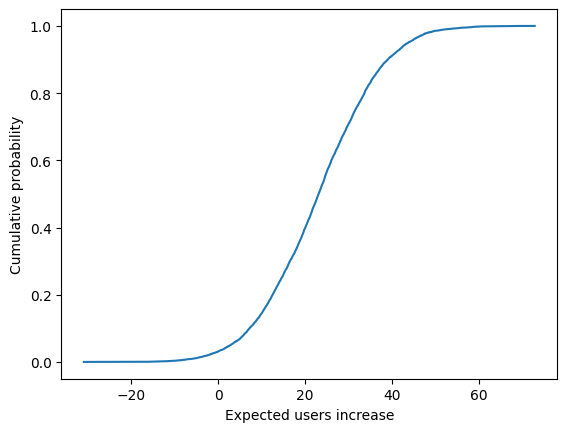

In [19]:
data = trace["p_new_web_diff"]
n = len(data)
x = np.sort(data * 1 * 1000)
y = np.arange(1, n + 1) / n

plt.plot(x, y)
plt.xlabel("Expected users increase")
plt.ylabel("Cumulative probability")